# Imports

In [12]:
import os, time

import s3fs

import xarray as xr
import rasterio
import numpy as np
import datetime
import matplotlib.pyplot as plt

from pyproj import Proj

import RasterClipperFunctions


# Setup

In [13]:
# choose basin
basin = str(12.0)

## also choose this in cell 5!

In [14]:
racmo_s3_dir = 's3://gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/*.netcdf4_classic.nc'

fs_s3 = s3fs.S3FileSystem(anon=False, profile='shionalyn')
racmo_s3_files = fs_s3.glob(racmo_s3_dir)


In [15]:
#racmo_s3_file = 's3://gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc'
racmo_s3_file = racmo_s3_files[0]

start = time.time()

f = fs_s3.open(racmo_s3_file, 'rb')
ds = xr.open_dataset(f) #, engine='netcdf4')
runoff = ds.variables['runoffcorr'] #[:,:,:].to_numpy() #[:,:,:]
x = ds.variables['x'].to_numpy() #[:]
y = ds.variables['y'].to_numpy() #[:]
ds.close()

end = time.time()
print('Elapsed time: {:5.1f} sec'.format(end-start))

#units = 'kg day^-1 m^-2'
#units = units.replace(' m^-2', '')


Elapsed time:   1.0 sec


# Create mask array
We'll use this mask array to extract runoff from RACMO grid cells within our basin

In [16]:
#p = Proj(proj='stere',lat_0=90,lat_ts=70,lon_0=-45,ellps='WGS84')
#area = 1000. * 1000. # hard-coded to 1 km by 1 km

# Shapefile
(xClip, yClip) = RasterClipperFunctions.basinUnionPolygon('gimpbasinspoly/gimpbasinspoly.shp', 'basin=12.0')

xm, ym = np.meshgrid(x, y)
iStep = x[1] - x[0]

geoTransform = (x[0]-iStep/2, iStep, 0, y[-1]+iStep/2, 0, -iStep)
maskArray = np.flipud(RasterClipperFunctions.clipImage(np.flipud(np.ones(xm.shape)), xClip, yClip, geoTransform))

maskArray_3d = np.broadcast_to(maskArray > 0.5, runoff.shape)


/home/jovyan/Climate-Model-Analysis/RasterClipperFunctions.py:59: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  polyUnion = cascaded_union(polys)


# Trials

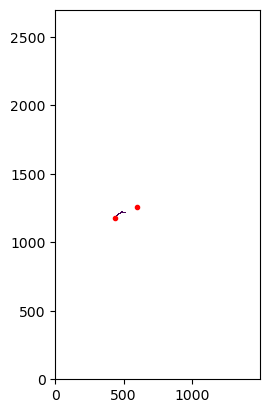

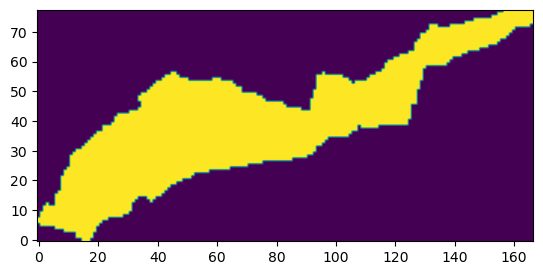

In [17]:
r = np.where(np.any(maskArray==True, axis=1)==True)
c = np.where(np.any(maskArray==True, axis=0)==True)
mask_ulr = r[0][0]
mask_ulc = c[0][0]
mask_lrr = r[0][-1]
mask_lrc = c[0][-1]

plt.imshow(maskArray, origin='lower')
#plt.plot(mask_ul[1], mask_ul[0], 'r.')
plt.plot(mask_ulc, mask_ulr, 'r.')
plt.plot(mask_lrc, mask_lrr, 'r.')
plt.show()

maskArray_clipped = maskArray[mask_ulr:mask_lrr,mask_ulc:mask_lrc]

plt.imshow(maskArray_clipped==True, origin='lower')
plt.show()


In [ ]:
# # Method 1
# racmo_s3_file = 's3://gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc'

# start = time.time()

# f = fs_s3.open(racmo_s3_file, 'rb')
# ds = xr.open_dataset(f) #, engine='netcdf4')
# runoff = ds.variables['runoffcorr'].to_numpy()
# runoffSum[i] = np.nansum(np.where(maskArray > 0.5, np.sum(runoff, axis=0), np.nan))
# maskArray_3d = np.broadcast_to(maskArray > 0.5, runoff.shape)
# runoffSum[idx:idx+runoff.shape[0]] = np.nansum(np.where(maskArray_3d, runoff, np.nan), axis=(1,2))

# print(time.time()-start)

# ds.close()

In [ ]:
# # Method 2
# #for i in range(idx, idx+runoff.shape[0]):
# #    runoffSum[i] = np.nansum(runoff[i,:,:].where(maskArray==1)) #, axis=(1,2))

# print(time.time()-start)

# ds.close()


In [ ]:
# # Method 3
# racmo_s3_file = 's3://gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc'

# start = time.time()

# f = fs_s3.open(racmo_s3_file, 'rb')
# ds = xr.open_dataset(f) #, engine='netcdf4')

# maskArray_3d = np.broadcast_to(maskArray_clipped > 0.5, runoff.shape)
# runoff = ds.variables['runoffcorr'][:,mask_ulr:mask_lrr,mask_ulc:mask_lrc].to_numpy()
# np.nansum(np.where(maskArray_3d, runoff, np.nan), axis=(1,2))

# print('Elapsed time: {:4.1f} sec'.format(time.time()-start))

In [18]:
racmo_s3_file = 's3://gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc'
#racmo_s3_file = racmo_s3_files[0]

start = time.time()

f = fs_s3.open(racmo_s3_file, 'rb')
ds = xr.open_dataset(f) #, engine='netcdf4')
#print(type(ds.variables['runoffcorr']))
runoff = ds.variables['runoffcorr'][:,mask_ulr:mask_lrr,mask_ulc:mask_lrc]
runoff_masked = ds.variables['runoffcorr'][-1,:,:].where(maskArray==1)
#print(ds.variables['runoffcorr'].where(maskArray_3d))
ds.close()

end = time.time()
print('Elapsed time: {:5.1f} sec'.format(end-start))


Elapsed time:   7.1 sec


In [ ]:
# # DO NOT RUN
# plt.imshow(runoff_all, origin='lower', vmin=0, vmax=50)
# #plt.plot(mask_ul[1], mask_ul[0], 'r.')
# plt.plot(mask_ulc, mask_ulr, 'r.')
# plt.plot(mask_lrc, mask_lrr, 'r.')
# plt.colorbar()
# plt.show()

# plt.imshow(runoff[-1,:,:], origin='lower', vmin=0, vmax=50)
# plt.colorbar()
# plt.show()

# plt.imshow(runoff_mask, origin='lower', vmin=0, vmax=50)
# plt.colorbar()
# plt.show()


In [ ]:
# # DO NOT RUN
# racmo_s3_file = 's3://gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc'

# start = time.time()

# f = fs_s3.open(racmo_s3_file, 'rb')
# ds = xr.open_dataset(f) #, engine='netcdf4')
# runoff = ds.variables['runoffcorr'] #[maskArray_3d].to_numpy() #[:,:,:]
# print(runoff.shape)
# print(maskArray_3d.shape)
# ds.close()

# end = time.time()
# print('Elapsed time: {:5.1f} sec'.format(end-start))

# #units = 'kg day^-1 m^-2'
# #units = units.replace(' m^-2', '')


# Loop through RACMO files

## Not dask

In [19]:
runoff_dts = list()
dt = datetime.date(int(2000), int(1), int(1))
while dt <= datetime.date(int(2021), int(12), int(31)):
    runoff_dts.append(dt)
    dt += datetime.timedelta(days=1)

runoff_dts = list()

#runoffSum = np.nan * np.zeros(len(racmo_s3_files))
runoffSum = np.nan * np.zeros( 9999 )
idx = 0
for racmo_s3_file in racmo_s3_files:
    print(racmo_s3_file)
    f = fs_s3.open(racmo_s3_file, 'rb')
    ds = xr.open_dataset(f) #, engine='netcdf4')
    
    start = time.time()
    runoff = ds.variables['runoffcorr'][:,mask_ulr:mask_lrr,mask_ulc:mask_lrc].to_numpy()
    maskArray_3d = np.broadcast_to(maskArray_clipped > 0.5, runoff.shape)
    runoffSum[idx:idx+runoff.shape[0]] = np.nansum(np.where(maskArray_3d, runoff, np.nan), axis=(1,2))
    runoff_dts.extend(ds.variables['time'].to_numpy())
    ds.close()
    print('  -> Elapsed time: {:5.1f} sec'.format(time.time()-start))
    
    idx += runoff.shape[0]
    
# Change units from mm w.e. to m3 per day
runoffSum_m3 = (runoffSum/1000.)*1000.*1000.


gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc
  -> Elapsed time:  17.7 sec
gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_JAS.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc
  -> Elapsed time:  19.5 sec
gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_JFM.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc
  -> Elapsed time:  18.2 sec
gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2000_OND.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc
  -> Elapsed time:  18.6 sec
gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2001_AMJ.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc
  -> Elapsed time:  19.5 sec
gris-outlet-glacier-seasonality-icesat2/Data/RACMO/RACMO2.3p2/runoff.2001_JAS.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.DD.netcdf4_classic.nc
  -> Elapsed time:  19.9 sec
gris-outlet-glacier-se

In [20]:
if not os.path.exists('output'):
    os.makedirs('output')

n = len(runoff_dts)
runoffSum_m3 = runoffSum_m3[:n]

runoff_dts = np.array(runoff_dts)

# Sort by time
idx = np.argsort(runoff_dts)
runoff_dts = runoff_dts[idx]
runoffSum_m3 = runoffSum_m3[idx]

runoff_years = runoff_dts.astype('datetime64[Y]').astype(int) + 1970
runoff_months = runoff_dts.astype('datetime64[M]').astype(int) % 12 + 1
runoff_days = runoff_dts - runoff_dts.astype('datetime64[M]') + 1

# Save output file - daily
f = open('output/'+basin+'_runoff_daily.csv', 'w')
for i, dt in enumerate(runoff_dts):
    f.write('{:4d}, {:2d}, {:2s}, {:10.2f}\n'.format(runoff_years[i], runoff_months[i], runoff_dts[i].astype(str)[8:10], runoffSum_m3[i]))
f.close()

# Sum over months
runoff_monthly_m3 = list()
for year in np.arange(2000,2022):
    for month in np.arange(1,13):
        idx = np.where(np.logical_and(runoff_years==year, runoff_months==month))
        runoff_monthly_m3.append(np.sum(runoffSum_m3[idx]))
        
# Save output file - monthly
f = open('output/'+basin+'_runoff_monthly.csv', 'w')
i = 0
for year in np.arange(2000,2022):
    for month in np.arange(1,13):
        f.write('{:4d}, {:2d}, {:10.2f}\n'.format(year, month, runoff_monthly_m3[i]))
        i += 1
f.close()


# Experimental code

In [ ]:
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr

import dask
from dask.distributed import Client
client = Client(n_workers=8)
client


In [ ]:
def gen_json(u):
    so = dict(
        mode="rb", anon=True, default_fill_cache=False,
        default_cache_type="none"
    )
    with fs_s3.open(u, **so) as inf:
        h5chunks = SingleHdf5ToZarr(inf, u, inline_threshold=300)
        with open(f"jsons/{u.split('/')[-1]}.json", 'wb') as outf:
           outf.write(ujson.dumps(h5chunks.translate()).encode())
        

In [ ]:
gen_json('s3://' + racmo_s3_files[0])


In [ ]:
import pathlib
pathlib.Path('./jsons/').mkdir(exist_ok=True)
dask.compute(*[dask.delayed(gen_json)('s3://' + u) for u in racmo_s3_files])


In [ ]:
from functools import partial

def _preprocess(array, mask):
    return array[:,:10,:10]

partial_func = partial(_preprocess, mask=maskArray)
#ds = xr.open_mfdataset("file_*.nc", concat_dim="time", preprocess=partial_func)  

f = fs_s3.open(racmo_s3_file, 'rb')
ds = xr.open_mfdataset(f, preprocess=partial_func)

In [ ]:
ds

## Dask

In [16]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/dfelikson/proxy/8787/status,
Dashboard: /user/dfelikson/proxy/8787/status,Workers: 1
Total threads: 4,Total memory: 30.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46389,Workers: 1
Dashboard: /user/dfelikson/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 30.90 GiB
Comm: tcp://127.0.0.1:42999,Total threads: 4
Dashboard: /user/dfelikson/proxy/41721/status,Memory: 30.90 GiB
Nanny: tcp://127.0.0.1:38601,


In [27]:
import time
import random

def runoff_sum_within_basin(racmo_s3_file, mask_ulr, mask_lrr,mask_ulc, mask_lrc, maskArray_clipped):
    f = fs_s3.open(racmo_s3_file, 'rb')
    ds = xr.open_dataset(f) #, engine='netcdf4')
    
    runoff = ds.variables['runoffcorr'][:,mask_ulr:mask_lrr,mask_ulc:mask_lrc].to_numpy()
    maskArray_3d = np.broadcast_to(maskArray_clipped > 0.5, runoff.shape)
    
    return np.nansum(np.where(maskArray_3d, runoff, np.nan), axis=(1,2))

In [ ]:
runoff_dts = list()
dt = datetime.date(int(2000), int(1), int(1))
while dt <= datetime.date(int(2021), int(12), int(31)):
    runoff_dts.append(dt)
    dt += datetime.timedelta(days=1)

runoff_dts = list()

#runoffSum = np.nan * np.zeros(len(racmo_s3_files))
runoffSum = np.nan * np.zeros( 9999 )
idx = 0
for racmo_s3_file in racmo_s3_files:
    runoff_sum_within_basin(racmo_s3_file, mask_ulr, mask_lrr,mask_ulc, mask_lrc, maskArray_clipped)
    

In [28]:
import dask
lazy_results = []

In [29]:
%%time

for racmo_s3_file in racmo_s3_files:
    lazy_result = dask.delayed(runoff_sum_within_basin)(racmo_s3_file, mask_ulr, mask_lrr,mask_ulc, mask_lrc, maskArray_clipped)
    lazy_results.append(lazy_result)

CPU times: user 6.28 ms, sys: 0 ns, total: 6.28 ms
Wall time: 5.81 ms


In [ ]:
%time dask.compute(*lazy_results)